

---

# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
print("TF version:", tf.__version__)

TF version: 2.12.0


In [4]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16,MobileNet

In [5]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---
# **Data**


In [7]:
main_split_dir ='/content/drive/MyDrive/Image Data Split/'
print(os.listdir(main_split_dir))
train_dir ='/content/drive/MyDrive/Image Data Split/Train/'
print(os.listdir(train_dir))
test_intra_dir ='/content/drive/MyDrive/Image Data Split/Test intra/'
print(os.listdir(test_intra_dir))
test_inter_dir ='/content/drive/MyDrive/Image Data Split/Test inter/'
print(os.listdir(test_inter_dir))

['Train', 'Test intra', 'Test inter']
['Anomaly', 'Normal', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']


In [8]:
#train
num_train_normal= len(os.listdir(train_dir+'Normal/'))
num_train_anomaly = len(os.listdir(train_dir+'Anomaly/'))
num_train_poor = len(os.listdir(train_dir+'Poor Quality/'))
Tot_train =  num_train_poor + num_train_anomaly + num_train_normal             

#test intra
num_test_intra_normal = len(os.listdir(test_intra_dir+'Normal/'))
num_test_intra_anomaly = len(os.listdir(test_intra_dir+'Anomaly/'))
num_test_intra_poor = len(os.listdir(test_intra_dir+'Poor Quality/'))
Tot_test_intra =  num_test_intra_normal + num_test_intra_anomaly + num_test_intra_poor

#test inter
num_test_inter_normal = len(os.listdir(test_inter_dir+'Normal/'))
num_test_inter_anomaly = len(os.listdir(test_inter_dir+'Anomaly/'))
num_test_inter_poor = len(os.listdir(test_inter_dir+'Poor Quality/'))
Tot_test_inter =  num_test_inter_normal + num_test_inter_anomaly + num_test_inter_poor

#table stat general
t = PrettyTable(['Class','Train','Test intra','Test inter'])
t.add_row(['Normal',num_train_normal,num_test_intra_normal,num_test_inter_normal])
t.add_row(['Anomaly',num_train_anomaly,num_test_intra_anomaly,num_test_inter_anomaly])
t.add_row(['Poor Quality',num_train_poor,num_test_intra_poor,num_test_inter_poor])
t.add_row(['Total',Tot_train,Tot_test_intra,Tot_test_inter])
print(t)

+--------------+-------+------------+------------+
|    Class     | Train | Test intra | Test inter |
+--------------+-------+------------+------------+
|    Normal    |  1303 |    241     |    241     |
|   Anomaly    |  469  |    136     |    106     |
| Poor Quality |  177  |     2      |     8      |
|    Total     |  1949 |    379     |    355     |
+--------------+-------+------------+------------+


In [9]:
import pandas as pd
def create_df(directory):
    file_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.png'): # or any other image format
                    file_path = os.path.join(class_path, file_name)
                    file_paths.append(file_path)
                    labels.append(class_folder)
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    return df

# Create DataFrames for train, validation, and test sets
train_df = create_df(train_dir)
test_intra_df = create_df(test_intra_dir)
test_inter_df = create_df(test_inter_dir)

# Print the number of images and classes in each set
print('Train set:', len(train_df), train_df['label'].nunique())
print('Test intra set:', len(test_intra_df), test_intra_df['label'].nunique())
print('Test inter set:', len(test_inter_df), test_inter_df['label'].nunique())

Train set: 1949 3
Test intra set: 379 3
Test inter set: 355 3


In [10]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [11]:
print('train set:', len(train), train['label'].nunique())
print('valid set:', len(valid), valid['label'].nunique())

train set: 1559 3
valid set: 390 3


In [12]:
# Create DataFrames for train, validation, and test sets
train_aug_df = create_df('/content/drive/MyDrive/Augmented data/')

# Print the number of images and classes in each set
print('Augmented Train spectograms:', len(train_aug_df), train_aug_df['label'].nunique())


Augmented Train spectograms: 1365 2


In [13]:
train_df = [train , train_aug_df ]
train_df = pd.concat(train_df)

In [14]:
anom_nbr =len(train_df[train_df.label == 'Anomaly'])

In [15]:
norom_nbr = len(train_df[train_df.label == 'Normal'])

In [16]:
poor_nbr = len(train_df[train_df.label == 'Poor Quality'])

In [17]:
anom_nbr

1206

In [18]:
norom_nbr

1045

In [19]:
poor_nbr

673



---

# **Datagens and smote**

In [192]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [193]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale = 1./255)

In [194]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [195]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [196]:
print(number_of_layers)

19


In [197]:
# Freeze the % layers in the base model
percent = 0.75
number_of_layers_to_freeze =  int(number_of_layers * percent)
print(number_of_layers_to_freeze)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

14


In [198]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(3, activation='softmax'))

In [199]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_13  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_27 (Bat  (None, 512)            

In [200]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming your DataFrame is called df and the target column is called 'class'
class_labels = train_df['label'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])

print("Class labels:", class_labels)
print("Class weights:", class_weights)

Class labels: ['Normal' 'Poor Quality' 'Anomaly']
Class weights: [0.93269537 1.4482417  0.80818132]


In [201]:
class_weights_dict = dict(zip([2,0,1], [1.8,3,1.5]))   #2 0 1 
print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {2: 1.8, 0: 3, 1: 1.5}


In [202]:
with tf.device(device_name):
  model.compile(
    optimizer="adamax",
    loss='categorical_crossentropy',
    metrics=['acc'])

In [203]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [204]:
# Define the number of folds for cross-validation
num_folds = 5
# Define the cross-validation method
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [205]:
# Initialize lists to store the training and validation metrics for each fold
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [206]:
# Loop over the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
    # Print the fold number
    print('Fold', fold+1)
    
    training_set = train_datagen.flow_from_dataframe(
            train_df.iloc[train_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')
    
    validation_set = val_datagen.flow_from_dataframe(
            train_df.iloc[val_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')

    # Train the model on the training data for this fold
    history = model.fit(training_set, epochs=10, batch_size = 64,
                        steps_per_epoch=len(training_set),
                        validation_data=validation_set, 
                        validation_steps=len(validation_set), 
                        callbacks=[early_stopping, plateau,checkpoint]
                        )
    
    # Get the training and validation metrics for this fold from the history object
    train_loss = history.history['loss'][-1]
    train_acc = history.history['acc'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_acc'][-1]
    
    # Append the training and validation metrics to the respective lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print the training and validation metrics for this fold
    print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
   

Fold 1
Found 2339 validated image filenames belonging to 3 classes.
Found 585 validated image filenames belonging to 3 classes.
Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 9.4183 - acc: 0.6383
Epoch 1: val_loss improved from inf to 11.33073, saving model to /content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/best_model.h5
37/37 [==============================] - 22s 506ms/step - loss: 9.4183 - acc: 0.6383 - val_loss: 11.3307 - val_acc: 0.4034 - lr: 0.0010
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 7.2525 - acc: 0.7469
Epoch 2: val_loss improved from 11.33073 to 9.93834, saving model to /content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/best_model.h5
37/37 [==============================] - 20s 530ms/step - loss: 7.2525 - acc: 0.7469 - val_loss: 9.9383 - val_acc: 0.3846 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 6.1100 - acc: 0.7713
Epoch 3: val_loss improved from 9.93834 to 8.1

In [207]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

**Test**

In [208]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc
import seaborn as sns

In [209]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [210]:
import numpy as np

def calculate_metrics(confusion_matrix):

    # create the confusion matrix
    cm = confusion_matrix

    # calculate the sensitivity and specificity
    TP = cm[0,0]
    FN = cm[0,1] + cm[0,2] 
    TN = cm[1,1] 
    FP = cm[1,0] + cm[1,2]
    Se = TP / (TP + FN)
    Sp = TN / (TN + FP)

    # calculate the average score and harmonic score
    AS = (Se + Sp) / 2
    HS = 2 * (Se * Sp) / (Se + Sp)

        #table stat general
    t = PrettyTable(['Class','SE','SP', 'AS','HS','Score'])
    t.add_row(['Normal',Se,Sp,AS,HS,(HS+AS)/2])
    print(t)
    return t

In [211]:
confusion_mat = np.array([[114,122,6],[115,329,38],[6,3,1]])

In [212]:
calculate_metrics(confusion_mat)

+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |          SE         |         SP         |         AS         |         HS         |       Score        |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.47107438016528924 | 0.6825726141078838 | 0.5768234971365865 | 0.5574364995615535 | 0.5671299983490701 |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+


In [213]:
test_intra_set = test_datagen.flow_from_dataframe(
            test_intra_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 379 validated image filenames belonging to 3 classes.


In [214]:
test_inter_set = test_datagen.flow_from_dataframe(
            test_inter_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 355 validated image filenames belonging to 3 classes.


In [215]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/best_model.h5')

In [216]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 0.9517
loss: 1.8203
val_acc: 0.9640
val_loss: 1.7980
---------------------last_epoch_model-----------------------
acc: 0.9517
loss: 1.8203
val_acc: 0.9640
val_loss: 1.7980




*   inter


In [217]:
# test evaluation INTER
with tf.device(device_name):
  print('TEST INTER')
  test_loss, test_acc = model.evaluate(test_inter_set)
  print('Test inter accuracy:', test_acc)
  print('Test inter loss:', test_loss)

TEST INTER
355/355 [==============================] - 5s 13ms/step - loss: 2.7823 - acc: 0.7099
Test inter accuracy: 0.7098591327667236
Test inter loss: 2.782325029373169


In [218]:
# test prediction INTER
with tf.device(device_name):
  test_inter_set.reset()
  Y_pred_inter = model.predict(test_inter_set)
  y_pred_inter = np.argmax(Y_pred_inter, axis=1)

355/355 [==============================] - 3s 9ms/step


In [219]:
#confusion mat inter
confusion_matrix_res_inter  = confusion_matrix(test_inter_set.classes, y_pred_inter)

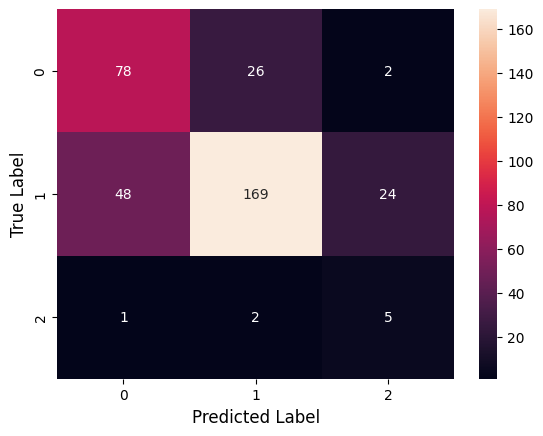

In [220]:
#plot inter
sns.heatmap(confusion_matrix_res_inter, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/confusion_matrix_res_inter.png')
plt.show()

In [221]:
#inter
print('inter')
print(classification_report(test_inter_set.classes, y_pred_inter, labels = [0, 1,2],digits=4))

inter
              precision    recall  f1-score   support

           0     0.6142    0.7358    0.6695       106
           1     0.8579    0.7012    0.7717       241
           2     0.1613    0.6250    0.2564         8

    accuracy                         0.7099       355
   macro avg     0.5444    0.6874    0.5659       355
weighted avg     0.7694    0.7099    0.7296       355



In [222]:
print('inter')
inter = calculate_metrics(confusion_matrix_res_inter)
with open('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/inter.txt', 'w') as f:
    f.write(str(inter))

inter
+--------+--------------------+--------------------+--------------------+-------------------+--------------------+
| Class  |         SE         |         SP         |         AS         |         HS        |       Score        |
+--------+--------------------+--------------------+--------------------+-------------------+--------------------+
| Normal | 0.7358490566037735 | 0.7012448132780082 | 0.7185469349408908 | 0.718130311614731 | 0.7183386232778108 |
+--------+--------------------+--------------------+--------------------+-------------------+--------------------+




*   intra


In [223]:
# test evaluation INTRA
with tf.device(device_name):
  print('TEST INTRA')
  test_loss_a, test_acc_a = model.evaluate(test_intra_set)
  print('Test intra accuracy:', test_acc_a)
  print('Test intra loss:', test_loss_a)

TEST INTRA
379/379 [==============================] - 4s 11ms/step - loss: 2.7661 - acc: 0.6332
Test intra accuracy: 0.6332454085350037
Test intra loss: 2.7661216259002686


In [224]:
# test prediction INTRA
with tf.device(device_name):
  test_intra_set.reset()
  Y_pred_intra = model.predict(test_intra_set)
  y_pred_intra = np.argmax(Y_pred_intra, axis=1)

379/379 [==============================] - 4s 10ms/step


In [225]:
#confusion mat intra
confusion_matrix_res_intra  = confusion_matrix(test_intra_set.classes, y_pred_intra)

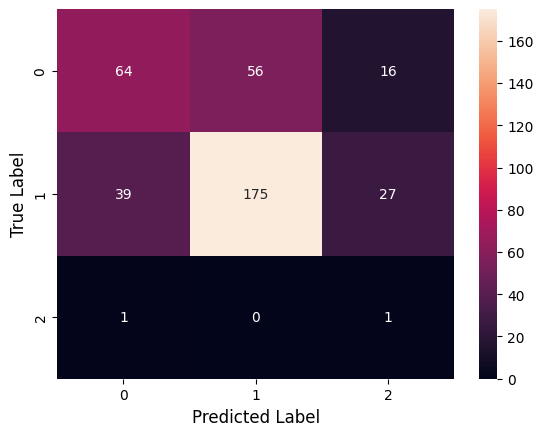

In [226]:
#plot intra
sns.heatmap(confusion_matrix_res_intra, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/confusion_matrix_res_intra.png')
plt.show()

In [227]:
#intra
print('intra')
print(classification_report(test_intra_set.classes, y_pred_intra, labels = [0, 1,2],digits=4))

intra
              precision    recall  f1-score   support

           0     0.6154    0.4706    0.5333       136
           1     0.7576    0.7261    0.7415       241
           2     0.0227    0.5000    0.0435         2

    accuracy                         0.6332       379
   macro avg     0.4652    0.5656    0.4394       379
weighted avg     0.7027    0.6332    0.6631       379



In [228]:
print('intra')
intra = calculate_metrics(confusion_matrix_res_intra)
with open('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/intra.txt', 'w') as f:
    f.write(str(intra))

intra
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |          SE         |         SP         |         AS         |         HS         |       Score        |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.47058823529411764 | 0.7261410788381742 | 0.5983646570661459 | 0.5710789312665715 | 0.5847217941663587 |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+




*   Merged test intra & inter



In [229]:
test_df = [test_intra_df , test_inter_df ]
test_df = pd.concat(test_df)

In [230]:
test_set = test_datagen.flow_from_dataframe(
            test_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 734 validated image filenames belonging to 3 classes.


In [231]:
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test intra accuracy:', test_acc)
  print('Test intra loss:', test_loss)

734/734 [==============================] - 8s 11ms/step - loss: 2.7740 - acc: 0.6703
Test intra accuracy: 0.6702997088432312
Test intra loss: 2.7739593982696533


In [232]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

734/734 [==============================] - 7s 9ms/step


In [233]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

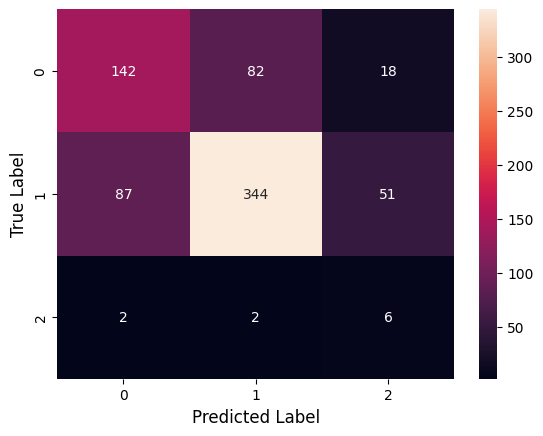

In [234]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/confusion_matrix_res.png')
plt.show()

In [235]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1,2],digits=4))

              precision    recall  f1-score   support

           0     0.6147    0.5868    0.6004       242
           1     0.8037    0.7137    0.7560       482
           2     0.0800    0.6000    0.1412        10

    accuracy                         0.6703       734
   macro avg     0.4995    0.6335    0.4992       734
weighted avg     0.7316    0.6703    0.6964       734



In [236]:
all = calculate_metrics(confusion_matrix_res)
with open('/content/drive/MyDrive/models (3 calsses)/VGG conf in 20 (aug)/inter-intra.txt', 'w') as f:
    f.write(str(all))

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |         SE         |         SP         |         AS         |         HS         |       Score        |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.5867768595041323 | 0.7136929460580913 | 0.6502349027811118 | 0.6440418743242886 | 0.6471383885527002 |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
import keras

In [ ]:
list1 = os.listdir('/content/drive/MyDrive/Image Data Split/Test inter/Anomaly')
list2 = os.listdir('/content/drive/MyDrive/Image Data Split/Test inter/Normal')
list3 = os.listdir('/content/drive/MyDrive/Image Data Split/Test inter/Poor Quality')
list1 = os.listdir('/content/drive/MyDrive/Image Data Split/Test intra/Anomaly')
list2 = os.listdir('/content/drive/MyDrive/Image Data Split/Test intra/Normal')
list3 = os.listdir('/content/drive/MyDrive/Image Data Split/Test intra/Poor Quality')

cp =0
for i in os.listdir('/content/drive/MyDrive/Image Data Split/Test inter/Normal/'):
    img_ori = cv2.imread('/content/drive/MyDrive/Image Data Split/Test inter/Normal/'+i)
    img = cv2.resize(img_ori, (224,224))
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    res = model.predict(x)
    res = np.argmax(res)
    if res == 1 :
        cp=cp+1
print(cp)

1/1 [==============================] - 0s 32ms/step
7
